Optimizing emergency flood response. 
Outline: 
1. Data 
1.1 Set & Index
1.2 Input parameters
2. Modeling
2.1 Run the model
2.2 Result and analysis

# Data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from optimization_model.vrp_humanitarian import HumanitarianReliefVRP, ReliefNetwork


In [2]:
# !pip install simpy
shelter_df = pd.read_excel('dataset/processed/shelters_Feni.xlsx')
warehouse_df = pd.read_excel('dataset/processed/warehouses_Feni.xlsx')
shelter_df.head()

,Unnamed: 0,ShelterNam,Capacity,Lat,Long,geometry,within_area,markersize
0,3361,Dakshin char dorbesh non gprs- cum-shelter,850,22.7991,91.3613,POINT (91.36133329228886 22.799094313320364),True,10.625
1,3374,Char Borodhali Health Complex,1000,22.8071,91.3865,POINT (91.38653656990846 22.807094493485376),True,12.500
2,3375,Rashadia cyclone shelter,1200,22.8084,91.3288,POINT (91.3288295012458 22.80839566480113),True,15.000
3,3380,Purba bara dhail gprs cum- shelter,950,22.8090,91.3822,POINT (91.38223604673483 22.808994733990435),True,11.875
4,3382,Paschim Char Darbesh Govt.Primary School,950,22.8103,91.3229,POINT (91.32292880755081 22.810295921261933),True,11.875


## Set and Index

In [3]:
shelters = [f'S{i}' for i in range(1, len(shelter_df))]
print(shelter_df.geometry)

0     POINT (91.36133329228886 22.799094313320364)
1     POINT (91.38653656990846 22.807094493485376)
2       POINT (91.3288295012458 22.80839566480113)
3     POINT (91.38223604673483 22.808994733990435)
4     POINT (91.32292880755081 22.810295921261933)
                          ...                     
72    POINT (91.50015701540917 23.104216633187576)
73     POINT (91.49735672382084 23.10451670488479)
74     POINT (91.42684908741172 23.15242192670002)
75     POINT (91.42684908741172 23.15242192670002)
76    POINT (91.43785120116823 23.185624441148995)
Name: geometry, Length: 77, dtype: object


## Input parameters

In [4]:
# Define your data: coordinates and optional attributes
data = {
    'Name': ['W1', 'W2'],
    'Latitude': [23.799094313320364, 22.899094313320364],
    'Longitude': [91.36133329228886, 91.28653656990846]  
}

# Create a GeoDataFrame
# Convert coordinates to Point objects
geometry = [Point(lon, lat) for lon, lat in zip(data['Longitude'], data['Latitude'])]
# Create the GeoDataFrame
warehouse_gdf = gpd.GeoDataFrame(data, geometry=geometry)
# Set the Coordinate Reference System (CRS) to WGS 84 (EPSG:4326)
warehouse_gdf.set_crs(epsg=4326, inplace=True)

shelters_Feni = gpd.read_file("dataset/processed/shelters_Feni/shelters_Feni.shp")
shelters_Feni.set_crs(epsg=4326, inplace=True) 
shelters_Feni['Name'] = [f'S{i}' for i in range(1, len(shelter_df)+1)]
shelters_location = [[point.x, point.y] for point in shelters_Feni.geometry]

gdf = gpd.GeoDataFrame(warehouse_gdf, geometry='geometry')
gdf.to_file("dataset/processed/warehouses_Feni/warehouses_Feni.shp")
warehouses_location = [[point.x, point.y] for point in warehouse_gdf.geometry]

In [5]:
warehouses = ['W1', 'W2']
#print(warehouse_locations)
#shelters = ['S1', 'S2', 'S3', 'S4']
shelters = [f'S{i}' for i in range(1, len(shelter_df)+1)]

import math
def compute_distance(loc1, loc2):
    """
    Compute distance between two geolocations given their coordinates
    :param loc1: latitude and longitude of point 1
    :param loc2: latitude and longitude of point 2
    :return: Distance (possibly in kilometer) between two points  
    """
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return math.sqrt(dx * dx + dy * dy)

distance = {(f'W{w+1}', f'S{s+1}'): compute_distance(warehouses_location[w], shelters_location[s])
                    for w in range(len(warehouses_location)) for s in range(len(shelters_location))}
# distance

### Resources

In [6]:
drones = ['D1', 'D2']
trucks = ['T1', 'T2']
vehicles = drones + trucks
demands = {shelters[i]: shelter_df.loc[i, 'Capacity'] for i in range(len(shelters))} # need to create more accurate data based on World Food Program (WFP)
""" # 25% coverage
availability = {'W1': 1500, 'W2': 2000} 
capacities = {'D1': 1000, 'D2': 2000, 'T1': 1600, 'T2': 2000}
"""
availability = {'W1': 1500, 'W2': 20000} 
capacities = {'D1': 1000, 'D2': 12000, 'T1': 1600, 'T2': 2000} 
# need to add a constraint saying that total transfer from each warehouse cant be greater than availability of that warehouse+++
# need to set proper connection between x and z. deploy from warehouse
# the edge in network diagram is currently based on x. 

ranges = {'D1': 25, 'D2': 25, 'T1': 50, 'T2': 50} # check the distance matrix (model could be infeasible)
population =  {shelters[i]: int(shelter_df.loc[i, 'Capacity']*0.9) for i in range(len(shelters))} # assuming 90% of capacity of that shelter
# print(population)

# Modeling

## Run the model

In [7]:
# Instantiate and solve the optimization model
vrp_model = HumanitarianReliefVRP(warehouses, shelters, vehicles, distance, demands, availability, capacities, ranges, population)
vrp_model.build_model()
vrp_model.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-03
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 249 rows, 701 columns and 2549 nonzeros
Model fingerprint: 0x24955f21
Variable types: 8 continuous, 693 integer (693 binary)
Coefficient statistics:
  Matrix range     [6e-02, 2e+03]
  Objective range  [1e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 164 rows and 58 columns
Presolve time: 0.00s
Presolved: 85 rows, 643 columns, 1209 nonzeros
Variable types: 0 continuous, 643 integer (643 binary)
Found heuristic solution: objective 29158.000000

Root relaxation: objective 2.988000e+04, 177 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

## Result and Analysis

Coverage: 46 %


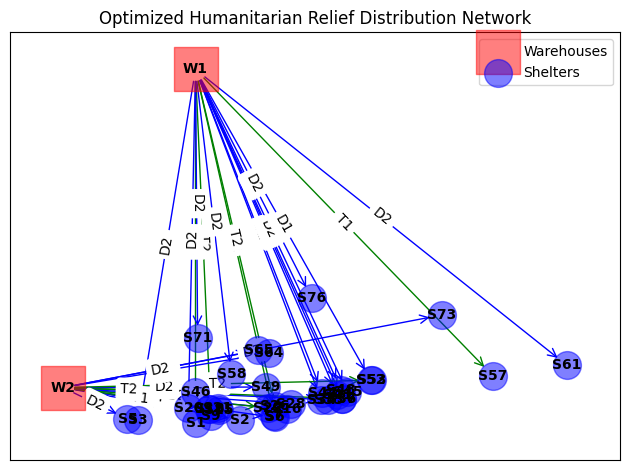

In [8]:
# Get the optimized routes
routes = vrp_model.get_routes()
print(f'Coverage: {100*len(routes)//len(shelters)} %')
# Extract coordinates from GeoDataFrame and create a dictionary
node_positions1 = {row['Name']: np.array([row['geometry'].x, row['geometry'].y]) for idx, row in warehouse_gdf.iterrows()}
node_positions2= {row['Name']: np.array([row['geometry'].x, row['geometry'].y])  for idx, row in shelters_Feni.iterrows()}
# for node_id, coord in zip(node_ids, coordinates)
node_positions0 = {**node_positions1, **node_positions2} #node_positions1.update(node_positions2)
keys_to_keep = [key for sublist in routes for key in sublist]
# Filter the dictionary to keep only the keys in `keys_to_keep`
node_positions = {k: node_positions0[k] for k in keys_to_keep if k in node_positions0}

# Instantiate and plot the network
relief_network = ReliefNetwork(warehouses_location, shelters_location, node_positions, demands)
relief_network.add_routes(routes)
relief_network.plot_network()

# Web Application